# Task 1: Exploratory Analysis and Hypothesis-Driven Bioinformatic Workflow
# Data Overview, Descriptive Statistics, and Analysis Planning

## Introduction

This notebook explores a colorectal cancer (CRC) bulk RNA-seq dataset to:

- Summarize clinical and molecular cohort characteristics  
- Visualize key variable distributions  
- Perform dimensionality reduction (PCA, UMAP) to uncover biological patterns or clusters  
- Generate hypotheses for downstream analyses based on data structure  

## Dataset Overview

- **Gene expression matrix:** Aggregated, batch-corrected bulk RNA-seq data  
- **Clinical metadata:** Patient and sample details including biopsy site, sample type (cancer/healthy), demographics (age, gender), and clinical variables  

## Sample Sources

Samples originate from three public datasets:

- **GEO (Gene Expression Omnibus):** Cancer and healthy samples  
- **GTEx (Genotype-Tissue Expression Project):** Healthy human tissues  
- **TCGA (The Cancer Genome Atlas):** Cancer tumors and a few normal samples  

This diversity offers a broad view of gene expression in healthy and diseased states.

## Tools & Libraries

Key Python libraries used:

- Data handling & visualization: `pandas`, `matplotlib`, `seaborn`, `plotly`  
- Dimensionality reduction & feature selection: `scanpy`  
- Normalization: `conorm`

## 1. Cohort Overview & Data Integrity

In this section, we perform an initial summary of the colorectal cancer (CRC) cohort and assess the integrity of the data. This includes:

- Summarizing the number of samples and patients
- Characterizing clinical variables shared between healthy and cancerous samples such as biopsy site, sample type, age, and gender.
- Clean the data when needed and handle missing values

Understanding the structure and quality of the data is critical before proceeding to downstream analyses.


In [92]:
# importing libraries
import pandas as pd
import conorm
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata
import warnings
warnings.filterwarnings("ignore")

# load the data
metadata_df = pd.read_csv('../data/CRC_atlas_clinical_data.csv', index_col=0)
expression_df = pd.read_csv('../data/CRC_atlas_gene_expression_data.csv', index_col=0)

### Dataset Overview and Metadata Summary

- **Total samples:** 2,770  
- **Metadata columns:** 34 


#### Key Metadata Highlights

- **Patient info:**  
  - `age`: available for 64% of samples.  
  - `gender`: 63% coverage.

- **Biopsy details:**  
  - `biopsy_site`: 100% coverage  
  - `biopsy_subsite`: 47% coverage  
  - `biopsy_timepoint`: 51% coverage  

- **Cancer-specific features:**  
  - Mutation status (e.g., `braf_mutation`, `kras_mutation`, `egfr_mutated`, `tp53_mutation`): ~19–22% coverage  
  - Molecular subtypes (`cms` 21%, `molecular_type` 9%, `msi_status` 28%)  
  - Tumor stage: 30%  
  - Tumor grade: 3%  

- **Treatment and outcomes:**  
  - Overall survival status/time: ~23%  
  - Progression-free survival status/time: 8% / 3%  
  - Therapy response: 21%  
  - Therapy type: 35%  

- **Sample and tumor types:**  
  - `sample_type`: 100%  
  - `tumor_type`: 71%  


In [93]:
# Display basic info
print("Clinical Data Overview:")
metadata_df.columns = metadata_df.columns.str.replace(' ', '_').str.lower()
display(metadata_df.shape)
display(metadata_df.info())
display(metadata_df.head())

Clinical Data Overview:


(2770, 34)

<class 'pandas.core.frame.DataFrame'>
Index: 2770 entries, GSM1133352 to TCGA-G5-6641-01A-11R-A32Z-07
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   1776 non-null   float64
 1   age_category          1442 non-null   object 
 2   biopsy_subsite        1296 non-null   object 
 3   braf_mutation         619 non-null    object 
 4   biopsy_site           2770 non-null   object 
 5   biopsy_timepoint      1425 non-null   object 
 6   cms                   581 non-null    object 
 7   cancer_type           631 non-null    object 
 8   distal_vs_proximal    1662 non-null   object 
 9   donor_type            2770 non-null   object 
 10  egfr_mutated          515 non-null    object 
 11  grade                 79 non-null     object 
 12  her2_mutation         0 non-null      float64
 13  histological_subtype  1966 non-null   object 
 14  histological_type     1966 non-null   object

None

,age,age_category,biopsy_subsite,braf_mutation,biopsy_site,biopsy_timepoint,cms,cancer_type,distal_vs_proximal,donor_type,...,pfs_time,sample_type,gender,stage,tmb,tmb_group,tp53_mutation,therapy_response,therapy_type,tumor_type
GSM1133352,80.0,NaN,NaN,NaN,Colon,NaN,NaN,NaN,NaN,Tumor,...,NaN,Healthy sample,F,NaN,NaN,NaN,NaN,NaN,NaN,Solid tumor
GSM1133353,80.0,NaN,NaN,NaN,Colon,NaN,NaN,NaN,NaN,Tumor,...,NaN,Primary cancer,F,NaN,NaN,NaN,NaN,NaN,NaN,Solid tumor
GSM1133355,76.0,NaN,NaN,NaN,Colon,NaN,NaN,NaN,NaN,Tumor,...,NaN,Healthy sample,F,NaN,NaN,NaN,NaN,NaN,NaN,Solid tumor
GSM2042099,NaN,NaN,NaN,NaN,Colon,NaN,NaN,NaN,NaN,Tumor,...,NaN,Primary cancer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Solid tumor
GSM2042100,NaN,NaN,NaN,NaN,Colon,NaN,NaN,NaN,NaN,Tumor,...,NaN,Primary cancer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Solid tumor


### Initial Data Cleaning

To prepare the dataset for downstream analysis, the following initial cleaning steps were performed:

- **Removed columns with only a single unique value:**  
  Columns that do not vary across samples (i.e., contain the same value for all samples) provide no informative signal and were excluded. This resulted in the removal of 5 such columns.

- **Removed columns with redundant or duplicated information:**  
  Certain columns contained overlapping or duplicated data, such as `sample_type` and `donor_type`. To avoid redundancy and potential confusion, one of each redundant pair was removed.

- **Filtered samples with inconsistent or contradictory metadata:**  
  A small number of samples exhibiting conflicting information across related columns (e.g., contradictory sample type and donor type annotations) were identified and excluded to ensure data integrity.

These cleaning steps ensure a more reliable and interpretable dataset for further analysis.

In [94]:
# Count unique values per column
unique_counts = metadata_df.nunique()

# Identify columns with only one unique value
cols_to_drop = unique_counts[unique_counts <= 1].index.tolist()

print("Dropped columns with a single unique value:")
for col in cols_to_drop:
    print(f"- {col}")

# Drop those columns
metadata_df = metadata_df.loc[:, unique_counts > 1]

print(f"Dropped {len(cols_to_drop)} columns in total.")


Dropped columns with a single unique value:
- age_category
- cancer_type
- her2_mutation
- line_of_treatment
- tumor_type
Dropped 5 columns in total.


#### Removing redundant columns and samples with contracting information

In [95]:
# Condition 1: donor_type == 'Tumor' → sample_type == 'Primary cancer'
cond1 = (metadata_df['donor_type'] == 'Tumor') & (metadata_df['sample_type'] != 'Primary cancer')
num_violations1 = cond1.sum()

print(f"Number of samples where donor_type is 'Tumor' but sample_type is NOT 'Primary cancer': {num_violations1}")


# Condition 2: donor_type == 'Normal' → sample_type == 'Healthy sample'
cond2 = (metadata_df['donor_type'] == 'Normal') & (metadata_df['sample_type'] != 'Healthy sample')
num_violations2 = cond2.sum()

print(f"\nNumber of samples where donor_type is 'Normal' but sample_type is NOT 'Healthy sample': {num_violations2}")

# filtering samples with contradicting information
metadata_df= metadata_df.loc[~ cond1]
expression_df = expression_df.loc[:, ~cond1]

metadata_df= metadata_df.loc[~ cond2]
expression_df = expression_df.loc[:, ~cond2]

metadata_df = metadata_df.drop(['donor_type'], axis=1)

Number of samples where donor_type is 'Tumor' but sample_type is NOT 'Primary cancer': 2

Number of samples where donor_type is 'Normal' but sample_type is NOT 'Healthy sample': 0


### Sample Composition and Source Distribution

To understand the composition of the cohort, I began by visualizing the distribution of sample types and their sources.

- **Sample Type Distribution:**  
  Approximately **30% of the samples are healthy**, while the remaining **70% are cancerous**. This imbalance is important to note, as it may influence downstream analyses, particularly classification tasks based on machine learning.

- **Data Source Distribution:**  
  The dataset aggregates samples from **three major public sources**:
  - **GTEx:** Provides only **healthy tissue** samples.
  - **TCGA:** Contributes **cancerous** colorectal tissue samples.
  - **GEO:** A mixed dataset, but predominantly composed of **cancerous** samples, and also the **largest contributor** in terms of sample count.

These initial visualizations provide important context for the analysis and highlight both the **heterogeneity of sources** and the **imbalance in class representation**, which should be considered in subsequent steps.


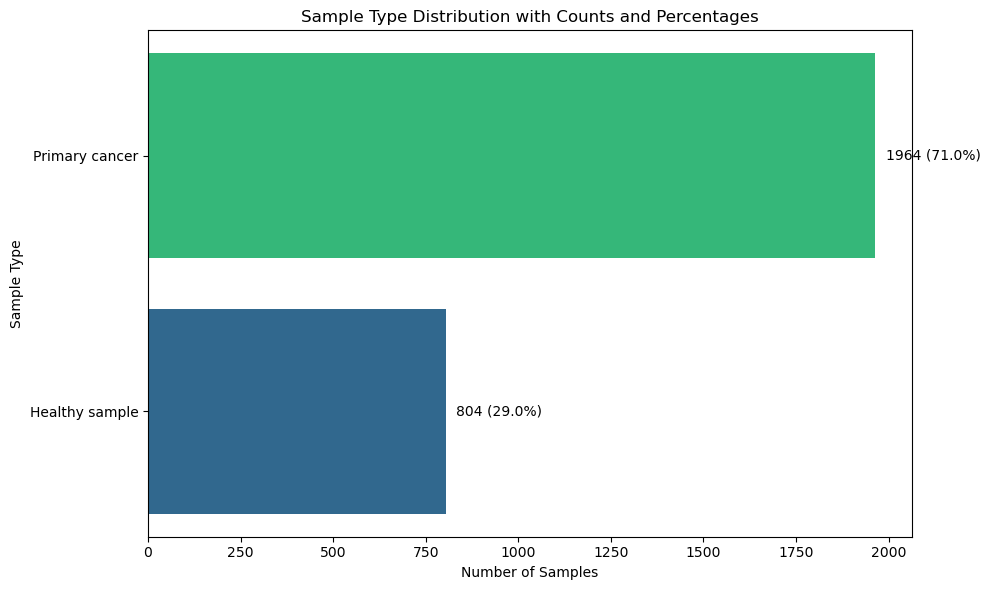

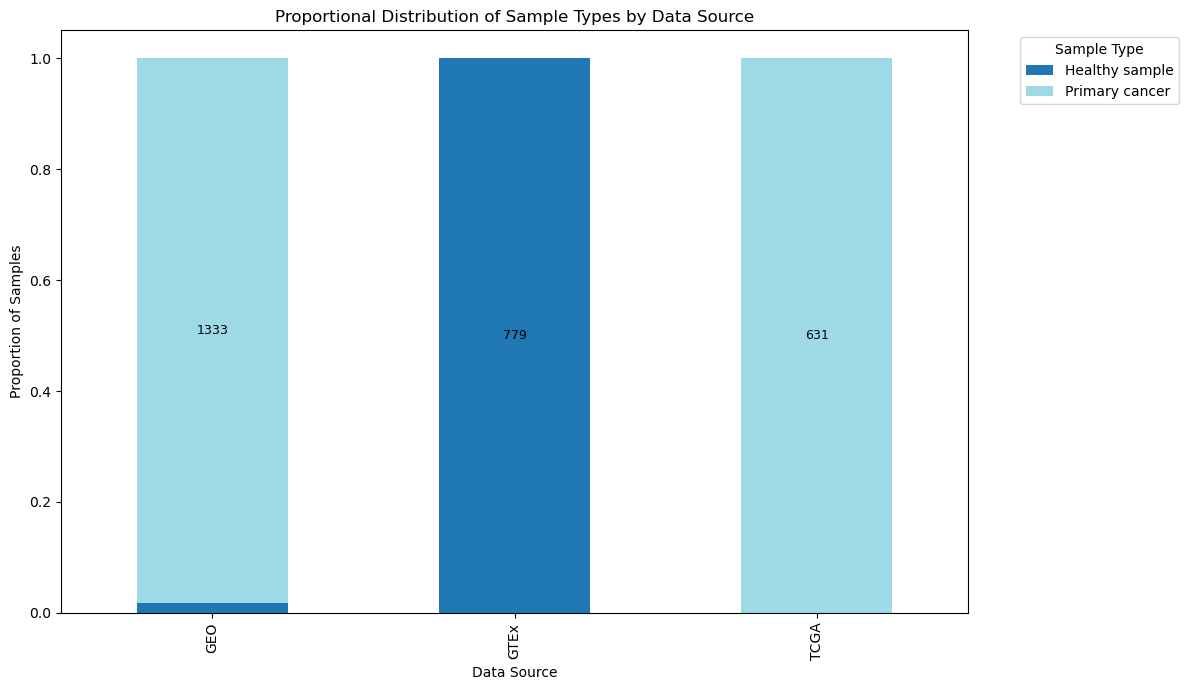

In [96]:
# Add a column indicating data source (GEO, GTEx, or TCGA)
# This function checks the prefix of the sample ID to assign the correct source
def get_data_source(sample_id):
    if sample_id.startswith('GSM'):
        return 'GEO'
    elif sample_id.startswith('GTEX'):
        return 'GTEx'
    elif sample_id.startswith('TCGA'):
        return 'TCGA'

# Apply the function to the sample IDs (which are used as index)
metadata_df['data_source'] = metadata_df.index.map(get_data_source)

# Horizontal bar chart of sample type distribution

# Count how many samples of each type (e.g., healthy, cancerous)
sample_type_counts = metadata_df['sample_type'].value_counts().sort_values()

# Total number of samples (used for calculating percentages)
total_samples = len(metadata_df)

# Create figure
plt.figure(figsize=(10, 6))

# Plot horizontal bar chart
bars = plt.barh(sample_type_counts.index,
                sample_type_counts.values,
                color=sns.color_palette("viridis", len(sample_type_counts)))

# Annotate each bar with the absolute count and percentage
for bar in bars:
    width = bar.get_width()
    plt.text(width + total_samples * 0.01,              
             bar.get_y() + bar.get_height() / 2,        
             f'{width} ({width / total_samples:.1%})', 
             va='center', fontsize=10)

# Add plot labels and formatting
plt.title('Sample Type Distribution with Counts and Percentages')
plt.xlabel('Number of Samples')
plt.ylabel('Sample Type')
plt.tight_layout()
plt.show()

# Stacked bar chart of sample type proportions by data source

# Create crosstab of data_source vs. sample_type
ct = pd.crosstab(metadata_df['data_source'], metadata_df['sample_type'], normalize='index')
ct_counts = pd.crosstab(metadata_df['data_source'], metadata_df['sample_type'])

# Plot the normalized stacked bar chart
ct.plot(kind='bar', stacked=True, colormap='tab20', figsize=(12, 7))
plt.title('Proportional Distribution of Sample Types by Data Source')
plt.xlabel('Data Source')
plt.ylabel('Proportion of Samples')

# Annotate bars with raw counts for each segment
for i, data_source in enumerate(ct.index): 
    cum_width = 0
    for sample_type in ct.columns:          
        val = ct.loc[data_source, sample_type]     
        count = ct_counts.loc[data_source, sample_type]
        if val > 0.05: 
            plt.text(i,
                     cum_width + val / 2,
                     f'{count}',
                     ha='center', va='center', fontsize=9, color='black')
        cum_width += val  

# Move legend outside the plot for clarity
plt.legend(title='Sample Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Biopsy Site Composition

The majority of samples in the dataset originate from the **colon**, which is expected given the colorectal cancer (CRC) focus of the study.

- **Healthy samples** are exclusively from the **colon**, with only a small number labeled as coming from the **colorectum**.
- **Tumor samples**, on the other hand, are more diverse in their biopsy site annotations, including **colon**, **colorectum**, and other redions like rectum and rectosigmoid function.

This distribution highlights a potential **sampling bias**, where healthy tissues are underrepresented in non-colon colorectal regions. This should be taken into account during comparative or site-specific analyses, especially when controlling for tissue location.


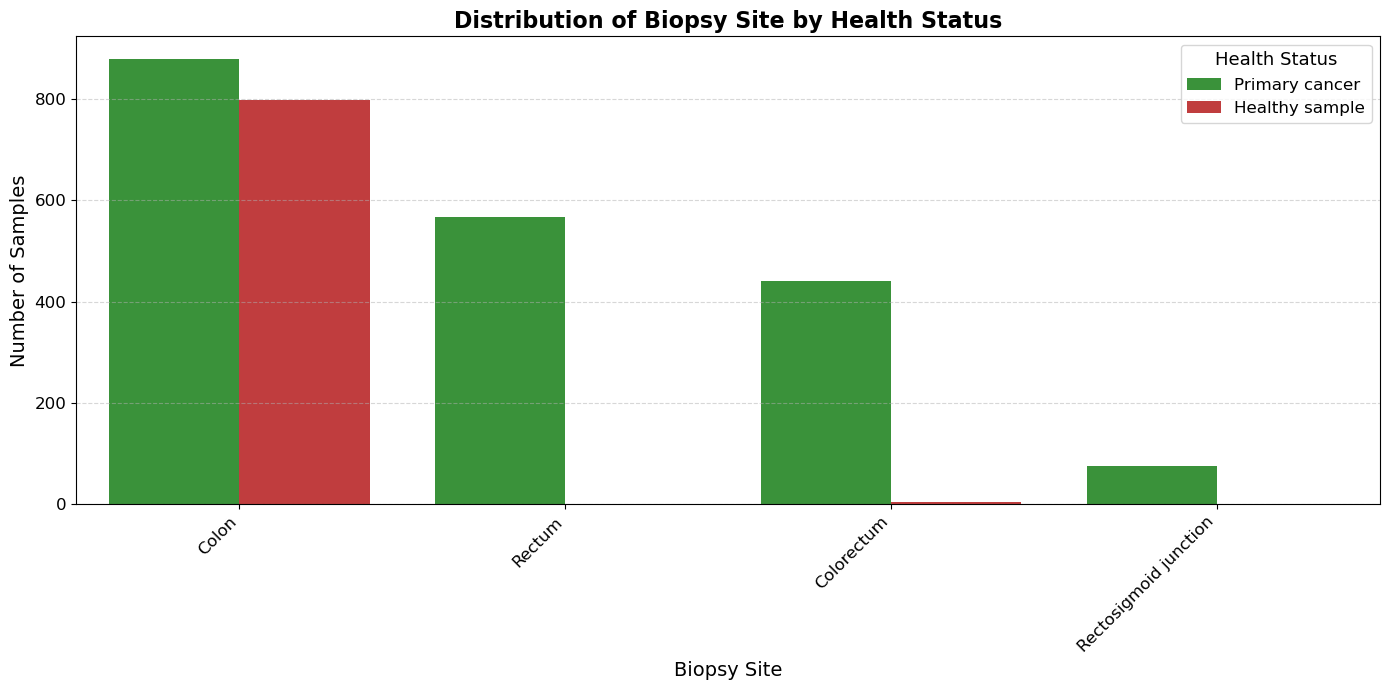

In [97]:
# Create a figure
plt.figure(figsize=(14, 7))

# Create a grouped bar chart (countplot) of sample counts per biopsy site
sns.countplot(
    data=metadata_df,
    x='biopsy_site',
    hue='sample_type',
    palette=['#2ca02c', '#d62728']  
)

# Add a descriptive title and axis labels
plt.title('Distribution of Biopsy Site by Health Status', fontsize=16, weight='bold')
plt.xlabel('Biopsy Site', fontsize=14)
plt.ylabel('Number of Samples', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Customize the legend
plt.legend(title='Health Status', title_fontsize='13', fontsize='12')

# Add horizontal grid lines to improve readability
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# Display the plot
plt.show()

### Age Distribution by Health Status

The **age** variable follows an approximately **normal distribution** overall, but with clear differences between healthy and cancerous samples:

- **Cancer samples** are centered around **older ages**, reflecting the typical onset age for colorectal cancer.
- **Healthy samples** tend to have a **younger distribution**, although all samples in the dataset are from **adults (18 years and older)**.

It's also important to note that approximately **35% of the samples are missing age information**. This level of missingness should be taken into account in downstream analyses, especially when age is considered a covariate. **Imputation** can be done using different techniques like **nearest neighbors** and **iterative imputing**.



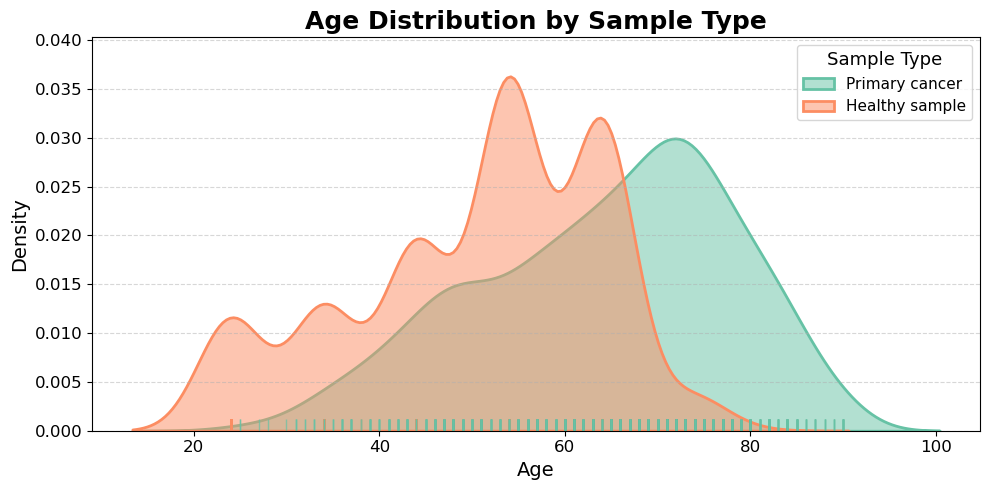

In [98]:
# Filter out missing age or sample_type
age_sample = metadata_df[['age', 'sample_type']].dropna()

plt.figure(figsize=(10, 5))

# Define colors with more contrast and saturation
palette = sns.color_palette('Set2', len(age_sample['sample_type'].unique()))

# Plot KDE with filled areas and a slight transparency
for i, stype in enumerate(age_sample['sample_type'].unique()):
    subset = age_sample[age_sample['sample_type'] == stype]['age']
    sns.kdeplot(subset, fill=True, alpha=0.5, linewidth=2, label=stype, color=palette[i])

# Add rug plot for individual data points
sns.rugplot(data=age_sample, x='age', hue='sample_type', palette=palette, height=0.03, alpha=0.7)

# Style enhancements
plt.title('Age Distribution by Sample Type', fontsize=18, weight='bold')
plt.xlabel('Age', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(title='Sample Type', title_fontsize='13', fontsize='11', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()



In [99]:
num_under_18 = (metadata_df['age'] < 18).sum()
total_samples = len(metadata_df)
print(f"Samples with Age < 18: {num_under_18} / {total_samples} ({num_under_18/total_samples:.1%})")

# Check how many missing in Age category
num_missing = metadata_df['age'].isna().sum()
total = len(metadata_df)
print(f"Missing values in 'Age': {num_missing} / {total} ({num_missing/total:.1%})")

Samples with Age < 18: 0 / 2768 (0.0%)
Missing values in 'Age': 994 / 2768 (35.9%)


### Gender Distribution by Health Status

The **gender** distribution is relatively **balanced between healthy and cancerous groups**, showing no major skew that would suggest sampling bias across health statuses.

- In both groups, **females are slightly underrepresented** compared to males.
- The proportions are similar between healthy and cancer samples, which supports the use of gender as a covariate if needed.

However, it's important to highlight that **gender data is missing for approximately 37% of the samples**. This significant missingness should be considered during analyses that include gender, and may require **imputation** (neares neighbor based on expression) or exclusion strategies depending on the context.


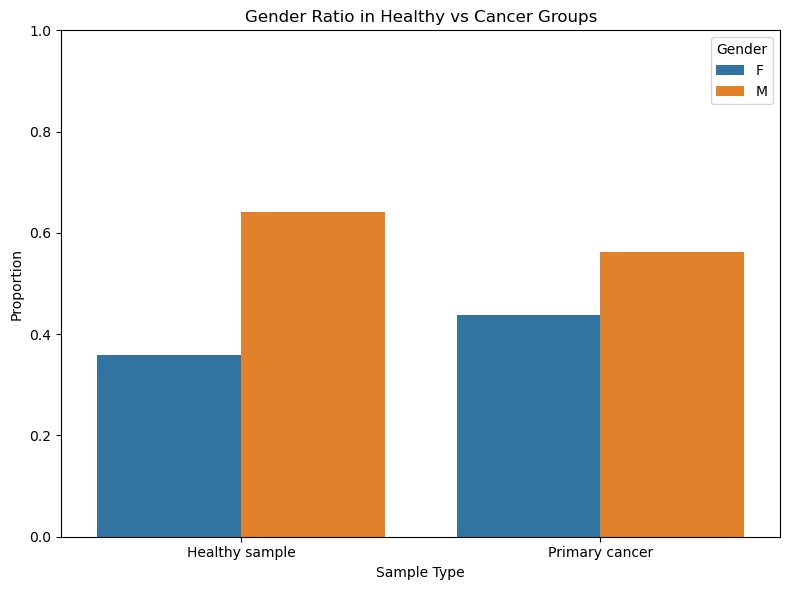

In [100]:
# Calculate counts
counts = metadata_df.groupby(['sample_type', 'gender']).size().reset_index(name='count')

# Calculate total counts per sample_type for ratio
totals = counts.groupby('sample_type')['count'].transform('sum')
counts['ratio'] = counts['count'] / totals

# Plot with ratios
plt.figure(figsize=(8,6))
sns.barplot(data=counts, x='sample_type', y='ratio', hue='gender')

plt.title('Gender Ratio in Healthy vs Cancer Groups')
plt.ylabel('Proportion')
plt.xlabel('Sample Type')
plt.ylim(0, 1)
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

In [101]:
# Check how many missing in Age category
num_missing = metadata_df['gender'].isna().sum()
total = len(metadata_df)
print(f"Missing values in 'Sex': {num_missing} / {total} ({num_missing/total:.1%})")

Missing values in 'Sex': 1037 / 2768 (37.5%)


#### 🔬 Normalization of Batch-Corrected Bulk RNA-seq Data

After batch correction using **ComBat-Seq**, I applied the following normalization steps:

1. **TMM Normalization**  
   - Performed using **CoNorm**, which implements the **Trimmed Mean of M-values (TMM)** method.
   - This corrects for differences in library size and composition between samples.

2. **Log Transformation**  
   - Applied log2 transformation with a pseudocount
   - Reduces skewness and stabilizes variance across genes.
   - after log transofrmation, I remove the genes that are present in less than 20% of the samples. **19823** genes are left after this filtering.
   - This data will be used in Scanpy for dimentionality reduction and highle variable gene analysis

3. **Z-score Scaling**  
   - Standardized each gene (row-wise) to mean 0 and standard deviation 1
   - Useful for downstream analysis like machine learning tasks. However, I will not be using it in the scope of my analysis.



In [102]:
# TMM normalization
expression_tmm = conorm.tmm(expression_df)
# Log scaling
log_tmm = np.log2(expression_tmm + 1)

# Keep genes expressed in at least 20% of the samples
min_samples = log_tmm.shape[1]//5
filtered_expr = log_tmm.loc[(log_tmm > 1).sum(axis=1) > min_samples,:]
expression_df.loc[filtered_expr.index]

# z-score calculation
scaler = StandardScaler()
scaled_log_tmm = pd.DataFrame(scaler.fit_transform(filtered_expr.T),
                              index=filtered_expr.columns,
                              columns=filtered_expr.index)
# examining final normalized file
scaled_log_tmm.shape

(2768, 19832)

#### Highly variable genes and visualization


1. **Highly variable genes**  
   - Using scanpy, I select the 200 most highly vatiable genes

2. **Visulaization**  
   - I visualize PCA, T-SNE, and UMAP. Healthy and cancerous samples are well seperated in all, with few exceptions. I remove these exceptions as they may represent errors/outliers and negatively affect the analysis by introducing noise. 25 samples were removed.

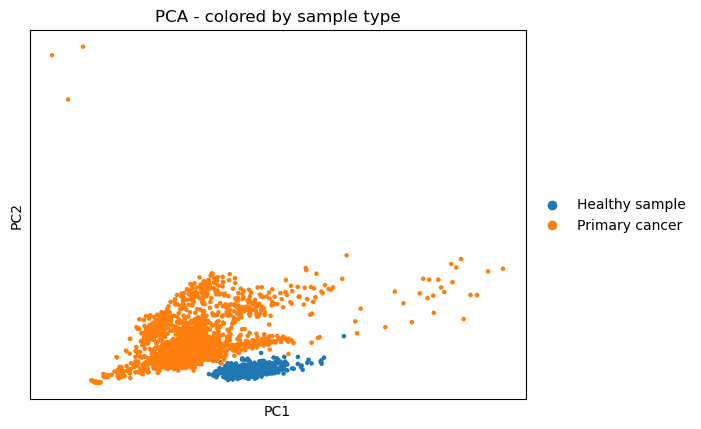

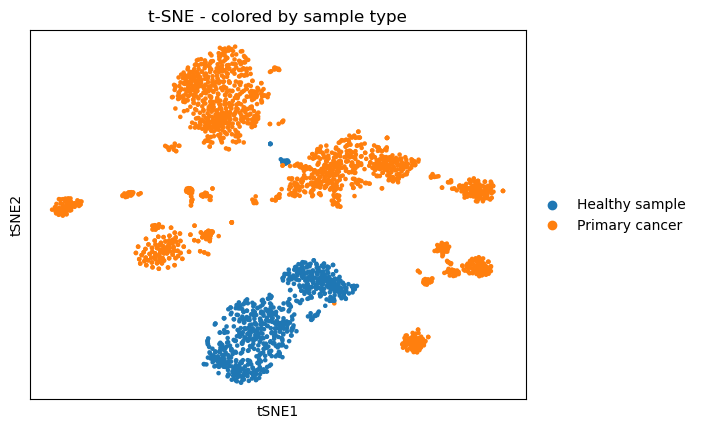

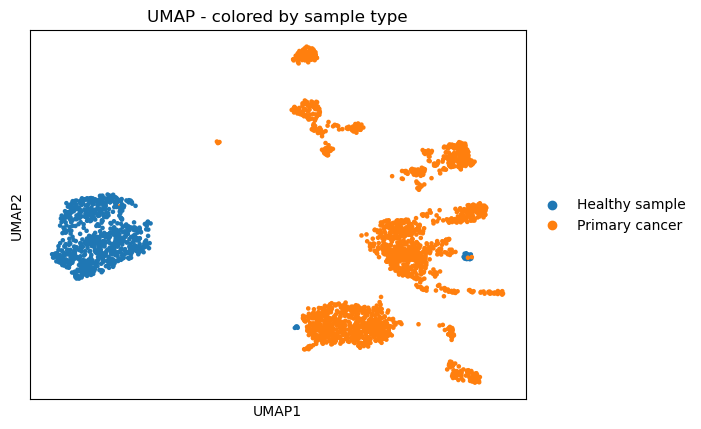

In [103]:
# Transpose dataset to have samples X genes
filtered_expr = filtered_expr.transpose()

# Creat AnnData object
adata = anndata.AnnData(filtered_expr)

# Check the match in index
metadata_df = metadata_df.loc[adata.obs_names]

# Add all columns from metadata_df to adata.obs
for col in metadata_df.columns:
    adata.obs[col] = metadata_df[col]

# Select Highly Variable Genes 
sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=200)
adata = adata[:, adata.var['highly_variable']]

# Scale data (z-score genes)
sc.pp.scale(adata)

# PCA
sc.tl.pca(adata)

# t-SNE
sc.tl.tsne(adata, use_rep='X_pca')

# UMAP
sc.pp.neighbors(adata, use_rep='X_pca')
sc.tl.umap(adata)

# Plot PCA colored by sample_type
sc.pl.pca(adata, color='sample_type', title='PCA - colored by sample type')

# Plot t-SNE colored by sample_type
sc.pl.tsne(adata, color='sample_type', title='t-SNE - colored by sample type')

# Plot UMAP colored by sample_type
sc.pl.umap(adata, color='sample_type', title='UMAP - colored by sample type')

### Finding the threshold to remove healthy samples with, 5 

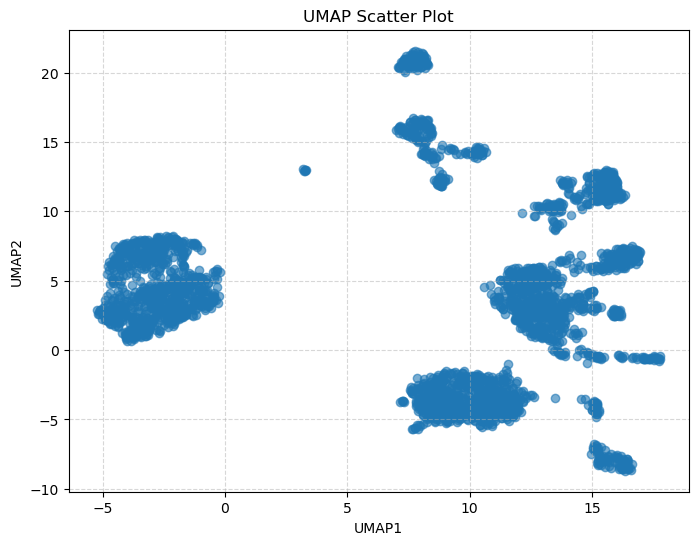

In [104]:
# Extract UMAP coordinates
umap1 = adata.obsm['X_umap'][:, 0]
umap2 = adata.obsm['X_umap'][:, 1]

plt.figure(figsize=(8, 6))
plt.scatter(umap1, umap2, alpha=0.6)

# Correct axis labels
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("UMAP Scatter Plot")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [105]:
# Extract UMAP1 scores (first column)
umap1_scores = adata.obsm['X_umap'][:, 0]

# Condition: keep non-healthy OR healthy with UMAP1 <= 5
mask = (adata.obs['sample_type'] == "Primary cancer") | (umap1_scores <= 5)

# Filter AnnData
adata = adata[mask, :].copy()
metadata_df.loc[mask].copy()

#number of non filtered samples
sum(mask)

2743

### Plotting after filtering to ensure it is done correctly

In [ ]:
# Plot PCA colored by sample_type
sc.pl.pca(adata, color='sample_type', title='PCA - colored by sample type')

# Plot t-SNE colored by sample_type
sc.pl.tsne(adata, color='sample_type', title='t-SNE - colored by sample type')

# Plot UMAP colored by sample_type
sc.pl.umap(adata, color='sample_type', title='UMAP - colored by sample type')

### Missing Data Handling Strategy

- **Healthy vs. Cancer Samples:**
  - For **current analysis**, samples with missing `age` or `gender` will be removed.  
    - Missingness for these variables is high, and sufficient sample size (1712) remains for differential expression (DE) and gene set enrichment analysis (GSEA).  

- **Cancer-focused analysis (Notebook 3):**
  - Will apply **iterative imputation** for missing `age` and `gender`.  
    - Missingness is lower, and preserving samples is important due to smaller dataset size.


In [108]:
# removing samples with missing age and gender information
metadata_nonan = metadata_df[metadata_df['age'].notna() & metadata_df['gender'].notna()]
metadata_nonan.shape

(1712, 29)

In [110]:

# saving the files
# Save AnnData object
adata.write("../data/adata.h5ad")

# Save dataframes i need for next analysis
metadata_df.to_csv('../data/metadata.csv')
metadata_nonan.to_csv('../data/metadata_nonan.csv')


expression_df.transpose().to_csv('../data/raw_expression.csv')
scaled_log_tmm.to_csv('../data/scaled_log_expression.csv')

# saving dimenionality reduction plots
fig, ax = plt.subplots()
sc.pl.pca(adata, color='sample_type', title='PCA - colored by sample type', ax=ax, show=False)
fig.savefig('../results/pca_sample_type.png')
plt.close(fig)

fig, ax = plt.subplots()
sc.pl.tsne(adata, color='sample_type', title='t-SNE - colored by sample type', ax=ax, show=False)
fig.savefig('../results/tsne_sample_type.png')
plt.close(fig)

fig, ax = plt.subplots()
sc.pl.umap(adata, color='sample_type', title='UMAP - colored by sample type', ax=ax, show=False)
fig.savefig('../results/umap_sample_type.png')
plt.close(fig)


# Colorectal Cancer Cohort: RNA-Seq & Clinical Metadata Analysis Plan

**Dataset:** Bulk RNA expression and clinical data for colorectal cancer (CRC) patients and healthy controls.  
**Goal:** Understand CRC biology, heterogeneity, treatment response, and survival despite some missing data.

---

## Dataset Summary

| **Variable Group**         | **Key Fields**                                                                                   | **Notes**                                           |
|----------------------------|------------------------------------------------------------------------------------------------|----------------------------------------------------|
| **Demographics**           | `age`, `gender`                                                                                 | Nearly complete; essential for model adjustment    |
| **Biopsy Info**            | `biopsy_site`, `biopsy_subsite`, `biopsy_timepoint`                                            | Spatial & temporal context for tumor progression   |
| **Cancer Features**        | `braf_mutation`, `kras_mutation`, `egfr_mutated`, `tp53_mutation`, `cms`, `msi_status`, `stage`| Moderate missingness; useful for precision stratification |
| **Treatment & Outcomes**   | `therapy_type`, `therapy_response`, `os_status`, `os_time`, `pfs_status`, `pfs_time`           | Critical for response and survival modeling        |
| **Sample Type**            | `sample_type` (healthy vs cancer), `tumor_type`                                                | Required for healthy vs tumor comparisons           |

---

## Analysis Plan Overview

### 1. Healthy vs Cancer Samples

#### A. Global Expression Profiling (Notebook 2)
- **Goal:** Identify key transcriptomic differences between healthy and CRC tissues.
- **Methods:**  
  - PCA, t-SNE/UMAP  
  - Differential expression (DESeq2, edgeR)  
  - Volcano plots, heatmaps  
  - Gene set enrichment analysis (GSEA: GO, KEGG)
- **Biological insight:** Key CRC pathways (WNT signaling, immune evasion, metabolism).

#### B. Effect of Age and Gender
- **Goal:** Examine gene expression variation by age and sex.
- **Methods:**  
  - Linear models with covariates  
  - Interaction terms (age × cancer status)
- **Insight:** Immune aging and sex-specific expression changes.

#### C. Supervised Classification
- **Goal:** Classify samples as healthy or cancer using gene expression.
- **Methods:**  
  - Random Forest, XGBoost, MLP on highly variable genes + demographics  
  - Permutation and SHAP for feature importance  
  - GSEA for pathway interpretation
- **Insight:** Confirm DE markers and identify robust classifiers.

---

### 2. Analyses Within Cancer Samples

#### D. Consensus Molecular Subtypes (CMS)
- **Goal:** Characterize CMS1–4 molecular subtypes transcriptionally.
- **Methods:**  
  - Clustering, subtype marker analysis  
  - Functional enrichment
- **Insight:** Link subtypes to clinical outcomes (e.g., CMS4 = poor prognosis).

#### E. Predicting Treatment Response
- **Goal:** Identify gene signatures predicting therapy outcomes.
- **Methods:**  
  - Random Forest, SVM  
  - LASSO feature selection  
  - ROC curves, cross-validation
- **Insight:** Biomarkers for chemo or EGFR-blockade resistance.

#### F. Survival Analysis
- **Goal:** Find gene expression patterns linked to survival.
- **Methods:**  
  - Cox regression (uni- and multivariate)  
  - Kaplan-Meier plots, risk scores  
  - Machine/deep learning: Random survival forest/Gradient Boosting (**Notebook 4**), DeepHit
- **Insight:** Prognostic genes (e.g., VEGF, MYC targets).

#### G. Patient Stratification (Notebook 3)
- **Goal:** Identify patient clusters and relate to clinical features.
- **Methods:**  
  - Highly variable genes, PCA + UMAP  
  - Clustering (Leiden, hierarchical)
- **Insight:** Molecular subgroups for personalized medicine.

---

## Optional Advanced Analyses

- **Cell-type deconvolution:** Use CIBERSORTx to estimate immune/stromal cell fractions from bulk RNA.
- **Gene co-expression networks:** WGCNA to identify gene modules linked to clinical traits (CMS, MSI, survival) and hub genes driving biology.




## Planned Analysis Direction

I will focus on the following two analyses:

1. **Global Expression Profiling**  
   Using the expression matrix and demographics for both cancer and healthy samples.  
   - Differential expression analysis with **pydeseq2**  
   - Gene set enrichment analysis (GSEA) with **pygsea** using **GO ontology**

2. **Survival Analysis (Overall Survival, OS)**  
   Integrating cancer clinical data with expression profiles.  
   - Data cleaning and exploratory clustering (highly variable genes based on cancer hallmarks, PCA, UMAP, Leiden clustering)  
   - Machine learning survival analysis using top features and clinical covariates

---

### ✅ Justification

**Why is this analysis valuable in the context of CRC?**  
- **Global profiling** captures tumor-specific transcriptomic changes, helping identify pathways and molecular patterns distinguishing CRC from normal tissue.  
- **Survival analysis**, combining gene expression and clinical data, helps uncover prognostic molecular markers with clinical relevance.

**What insight do you aim to generate?**  
- Gene and pathway signatures differentiating healthy vs cancer tissue.  
- Gene-level and clinical predictors associated with overall survival in CRC.

---

### Important Considerations

- **Missing values:**  
  - For the first analysis (global profiling), samples with missing data are removed due to low missingness and large sample size.  
  - For the second analysis (survival), features with high missingness are dropped; remaining missing values are imputed using an iterative imputer. Alternative imputers like KNN could be tested and compared.  
  - Different analyses may require tailored missing data handling, which should be incorporated into the pipelines.

- **Gene set choice for GSEA:**  
  - Use general GO ontology in the first analysis, as it sufficiently differentiates groups.  
  - Use cancer hallmark gene sets in the second analysis because general ontologies may miss survival-associated differences.

- **Pipelines and automation:**  
  - Scripts automate key analysis steps:  
    - Differential expression with pydeseq2 (pipeline used in Notebook 3)  
    - Reusable plotting functions (used in subsequent notebooks)  
    - Survival analysis pipeline (tested in Notebook 4)

- **Validation and data integration:**  
  - Using external datasets for validation strengthens the robustness and generalizability of findings.  
  - Integration of multi-omics data (e.g., mutation, methylation, proteomics) can provide a richer biological context and improve model performance.

---


<!-- ### Important consideration

- missing values: missing value handling needs to be adjusted to the study, i remove samples with the first analysis since the percentage is not very high and the number of samples are high as well. In the second analysis I drop columns with high percentage of missing values and impute the missing values for the rest using iterative imputer, ideally different imputer could be tested and compared (knn for example). Different analysis needs further adjustment and that need to be captured in the pipelines in the pipelines
- I do differntial gene expression and gsea with general GO ontology in the first analysis since it was good enough to differentiate the groups i have, i use cancer hallmark in the second since the general databases were not enough to capture the difference.

- pipelines and automation: in the scripts folder, i automate some chuncks of the analysis: de+pydeseq (pipeline used in notebook3), repeatedly used plots (used in the next notebooks), survival analysis (tested in notebook4) -->

---